In [1]:
import os
import abagen
import json
import nibabel as nib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from src.ni_functions import *
from src.tree_functions import *
import pandas as pd
from glob import glob
from scipy.stats import zscore

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(conn_size),
        "optimal_parcellation.nii.gz",
    )
)
optimal_parcellation_data = optimal_parcellation.get_fdata()

In [4]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv")):
    transcriptome = pd.read_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv"), index_col=0)
    print("transcriptome loaded from tmp folder")
    transcriptome = transcriptome.dropna(axis=1)
else:
    transcriptome = pd.DataFrame.transpose(abagen.get_expression_data(nib.Nifti1Image(optimal_parcellation_data, optimal_parcellation=atlas.affine)))
    transcriptome.to_csv(os.path.join(project_path, "tmp", "transcriptome_" + str(int(np.max(optimal_parcellation_data))) + "modules.csv"), index=True)
    transcriptome = transcriptome.dropna(axis=1)


transcriptome loaded from tmp folder


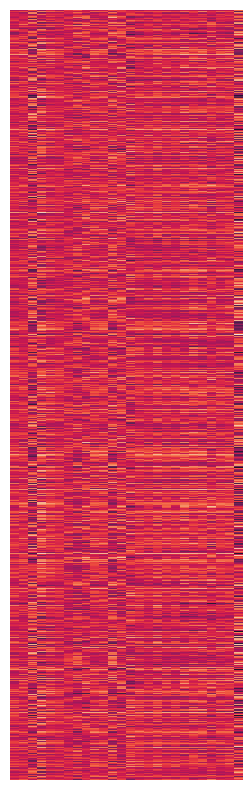

In [34]:
plt.rcParams['figure.figsize'] = [3, 10]
sns.heatmap(transcriptome, cbar=False, xticklabels=False, yticklabels=False)
plt.ylabel("")
plt.savefig(
    os.path.join(project_path, "data", "figures", "gene_parcellation.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)

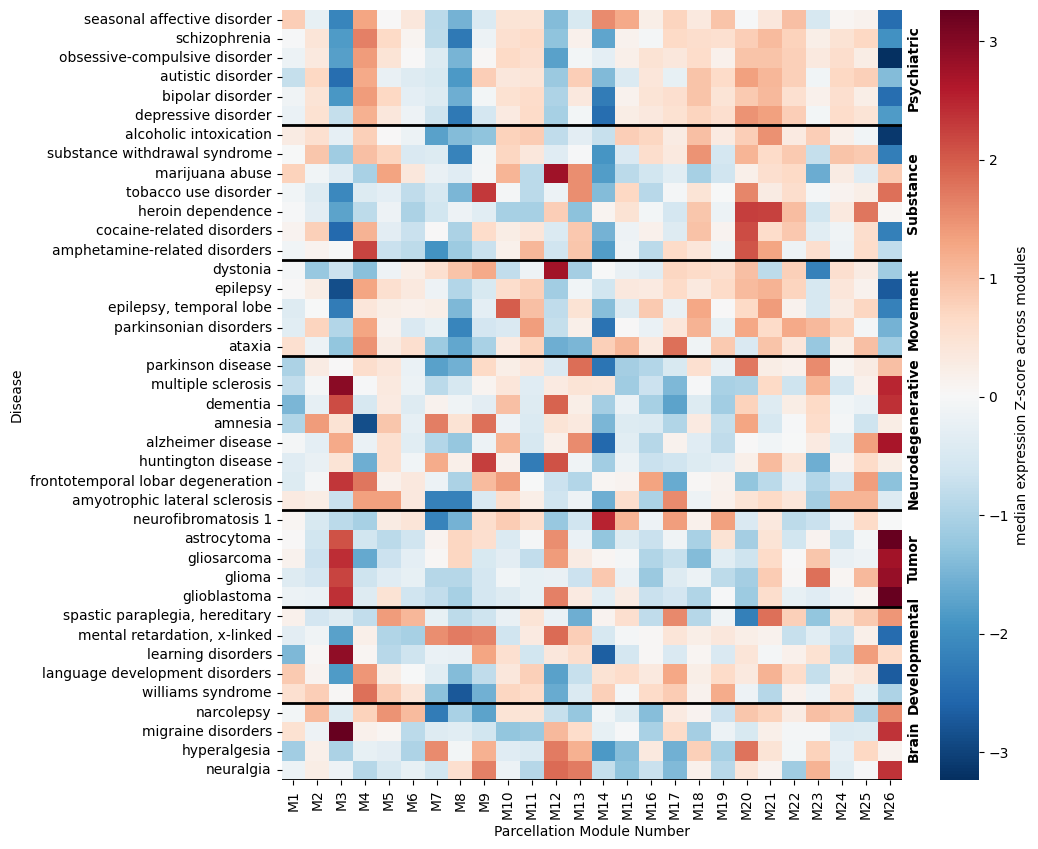

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]

diseaseWHO_class = pd.read_csv(os.path.join(project_path, "data", "raw", "DiseaseWHOClass.csv"), index_col=0).sort_values(by=['Class'])
disease_name = diseaseWHO_class.index.values
WHOclass_names = ['Psychiatric', 'Substance',  'Movement', 'Neurodegenerative', 'Tumor', 'Developmental', 'Brain']
diseaseWHO_class["Class_name"] = diseaseWHO_class.Class.map({(i+1):WHOclass_names[i] for i in range(len(WHOclass_names))})


avg_exp_in_parcel = np.zeros((len(disease_name), transcriptome.shape[1]))
for idx_dis, dis in enumerate(disease_name):
    genes_in_dis = pd.read_csv(os.path.join(project_path, "data", "raw", "disease_genes", disease_name[idx_dis] + ".csv"), index_col=0)["x"].values
    transcriptome_in_dis = transcriptome.loc[transcriptome.index.isin(genes_in_dis), :]
    for m_parcel in range(transcriptome.shape[1]):
        avg_exp_in_parcel[idx_dis, m_parcel] = np.median(transcriptome_in_dis.iloc[:, m_parcel])
avg_exp_in_parcel_z = zscore(avg_exp_in_parcel, axis=1)
hmap = sns.heatmap(avg_exp_in_parcel_z, cmap="RdBu_r", cbar_kws={'label': 'median expression Z-score across modules'},
            yticklabels=disease_name, xticklabels=["M"+str(transcriptome.columns[m_number]) for m_number in range(transcriptome.shape[1])])

line_offset = 0
for who_classes in range(np.min(diseaseWHO_class["Class"]), np.max(diseaseWHO_class["Class"])+1):
    n_diseases_in_class = len(diseaseWHO_class[diseaseWHO_class["Class"]==who_classes])
    line_offset += n_diseases_in_class
    text_offset = line_offset - n_diseases_in_class/2
    hmap.axhline(line_offset, color="black", linewidth=2)
    # add the name of the class at the right of the line
    hmap.text(transcriptome.shape[1]+0.5, text_offset, diseaseWHO_class[diseaseWHO_class["Class"]==who_classes]["Class_name"].values[0], fontsize=10, fontweight="bold", rotation=90, va="center", ha="center")


plt.xlabel("Parcellation Module Number")
plt.ylabel("Disease")

plt.savefig(
    os.path.join(project_path, "data", "figures", "genetic_disorders.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
